In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# in house functions: 
%run 'DST_fun.ipynb' # model_report() and review_vector() 

# Load the dataset
train_df = pd.read_csv("../data/avis/train_noYC_lemma_sent_equil.csv", index_col=0)
y_train = train.etoiles
X_train = train.drop("etoiles", axis = 1)
X_train = X_train[['n_avis','sentiment_norm','longueur_texte']]
extra_features = X_train.columns.values

test_df = pd.read_csv('../data/avis/test_noYC_lemma_sent_equil.csv')
y_test = test['etoiles']
X_test = test.drop("etoiles", axis =1)
X_test = X_test[['n_avis','sentiment_norm','longueur_texte']]

model_type = "Random Forest"

train_df.head(2)

,Unnamed: 0,user,etoiles,n_avis,date_avis,date_experience,Société,text_total,jour_avis,mois_avis,...,mois_experience,heure_experience,annee_experience,periode_avis,longueur_texte,text_stop,text_lemma,label,score,sentiment_norm
5529,5529,Benjamin Danneville,5,1.0,2021-04-26,2021-04-26,Shine,Permet de faire des factures et des…Permet de ...,26,4,...,4,0,2021,nuit,95,Permet faire factures … Permet faire factures ...,permettre faire facture … permettre faire fact...,1,0.804014,0.804014
57109,120764,Gillot Frederic,5,1.0,2022-01-16,2022-01-16,Immoprt,"Bien accompagnéBien accompagné, sympathique, p...",16,1,...,1,0,2022,nuit,73,"Bien accompagnéBien accompagné , sympathique ,...","bien accompagnébien accompagner , sympathique ...",1,0.974431,0.974431


train score:  0.36
              precision    recall  f1-score   support

           1       0.43      0.19      0.26       562
           2       0.33      0.09      0.15       562
           3       0.28      0.64      0.39       562
           4       0.18      0.02      0.04       562
           5       0.47      0.88      0.61       562

    accuracy                           0.36      2810
   macro avg       0.34      0.36      0.29      2810
weighted avg       0.34      0.36      0.29      2810



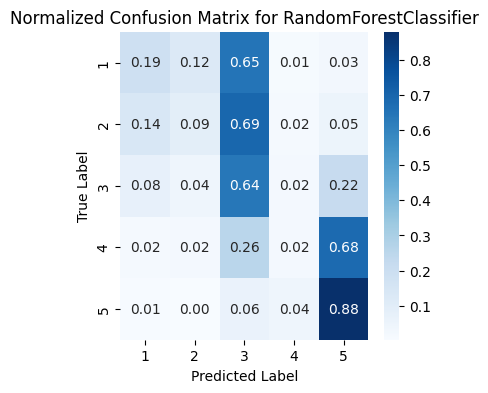

In [48]:
# Vectorization des avis lémmatisés
X_train = review_vector(train_df,['n_avis','sentiment_norm','longueur_texte'])
X_test = review_vector(test_df,['n_avis','sentiment_norm', "longueur_texte"])
# Train the Random Forest model
t0 = time.time()
model = RandomForestClassifier(n_estimators=10, max_depth=10,
                               random_state=7)
model.fit(X_train, y_train)
model_report()

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.518 total time=   2.3s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.541 total time=   2.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.513 total time=   2.3s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.504 total time=   2.4s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.531 total time=   2.4s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.559 total time=   9.7s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.581 total time=   9.7s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.562 tot

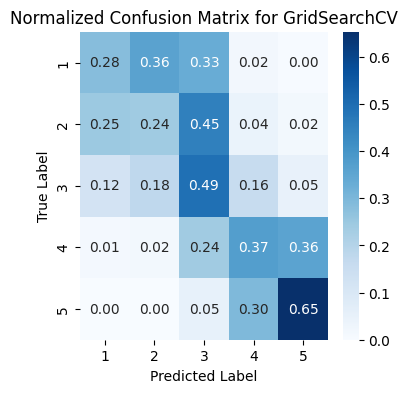

In [49]:
# Essai grid
# definir des hyper paramètres à tester
param_grid = {'n_estimators': [10, 50, 100, 200, 300],  
              'max_depth': [None, 10, 20, 30], 
              'min_samples_split': [2, 5, 10, 20, 30 ],
              'min_samples_leaf':[1, 2, 4]
              } 
# tester les différents paramètres
t0= time.time()
model = GridSearchCV(RandomForestClassifier(random_state=7), param_grid, cv = 5, n_jobs=-1, verbose = 3)
model.fit(X_train, y_train)

In [50]:
model_report()
print("Best parameters:", model.best_params_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


# Best score on test is .66 with Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

In [76]:
bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
bench[bench.model == type(model).__name__]

,model,grid search,used/best params,features,score,precision,recall,f1,time_taken_mns,run_date
